In [1]:
import masknmf
import os
import torch
import numpy as np
import sys
import tifffile
from tqdm import tqdm
import math
import fastplotlib as fpl
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy.ndimage as ndi
import skimage
from typing import *
import h5py

import plotly.graph_objects as go
import plotly.subplots as sp

from scipy.signal import find_peaks

%load_ext autoreload
%matplotlib inline

fastplotlib version from git (0.2.0) and __version__ (0.5.0) don't match.
No config found!
EGL says it can present to the window but not natively
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA TITAN RTX,DiscreteGPU,Vulkan,555.42.02
❗ limited,"llvmpipe (LLVM 12.0.0, 256 bits)",CPU,Vulkan,Mesa 21.2.6 (LLVM 12.0.0)
❌,NVIDIA TITAN RTX/PCIe/SSE2,Unknown,OpenGL,3.3.0 NVIDIA 555.42.02


Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


In [2]:
data = tifffile.imread('../plane_07_subsample.tif').astype('float')

RFBOutputContext()

Max vertex attribute stride unknown. Assuming it is 2048
/data/home/app2139/fastplotlib/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
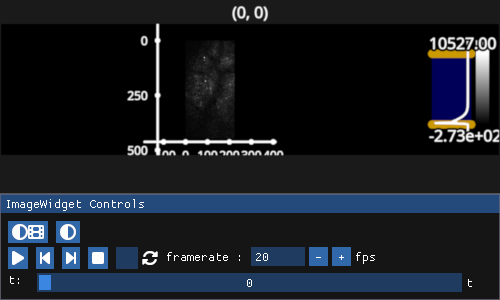

In [3]:
iw = fpl.ImageWidget(data = data)
iw.cmap = "gray"
iw.show()

In [4]:
max_rigid_shifts = [10, 10]
template = None
rigid_strategy = masknmf.RigidMotionCorrection(max_rigid_shifts, template = template)

In [5]:
rigid_strategy = masknmf.compute_template(data,
                                          rigid_strategy, 
                                          device = "cuda")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


In [6]:
moco_results = masknmf.RegistrationArray(data,
                                         rigid_strategy,
                                         device = "cuda")

moco_dense = moco_results[:]

In [11]:
# pixel_weighting = np.std(full_moco_dense, axis = 0)
pmd_arr_moco = masknmf.compression.pmd_decomposition(moco_dense[:, 10:-10, 10:-10],
                                                [32, 32],
                                                moco_dense.shape[0],
                                                max_components = 20,
                                                max_consecutive_failures = 1,
                                                temporal_avg_factor=4,
                                                spatial_avg_factor=1,
                                                background_rank = 0,
                                                device = "cuda",
                                                pixel_weighting=None,
                                                frame_batch_size = 1024)

[25-05-23 00:21:57]: Starting compression
[25-05-23 00:21:57]: sampled from the following regions: [0]
[25-05-23 00:21:57]: We are initializing on a total of 5312 frames
[25-05-23 00:21:57]: Approximating full FOV basis terms
[25-05-23 00:21:57]: Loading data to estimate complete spatial basis
[25-05-23 00:21:58]: Finding spatiotemporal roughness thresholds


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 274.93it/s]

[25-05-23 00:21:59]: Running Blockwise Decompositions


[25-05-23 00:22:02]: Constructed U matrix. Rank of U is 1261
[25-05-23 00:22:02]: PMD Objected constructed


In [8]:
# pmd_arr_moco.to('cuda')

In [9]:
# residual_array = masknmf.PMDResidualArray(moco_dense, pmd_arr_moco)

In [10]:
# iw = fpl.ImageWidget(data = [moco_dense, pmd_arr_moco, residual_array],
#                      names = ['moco', 'pmd', 'moco - pmd'],
#                     figure_shape = (1, 3))
# iw.cmap = "gray"
# iw.show()

In [11]:
pmd_arr_moco.shape

(1935, 448, 224)

In [25]:
a = moco_dense[:, 50:100, 50:100].mean(axis=(1,2))



In [26]:
b = pmd_arr_moco[:, 50:100, 50:100].mean(axis=(1, 2))

In [27]:
%%timeit 
a - b

1.43 μs ± 7.39 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [12]:
my_w = masknmf.visualization.PMDWidget(moco_dense, 
                                       pmd_arr_moco,
                                       device='cuda')
my_w.show()

[25-05-22 09:18:08]: Computing Residual Statistics
[25-05-22 09:18:08]: Residual Statistics: Complete


RFBOutputContext()

RFBOutputContext()

In [12]:
device = 'cuda'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
    pmd_arr_moco,
    device=device,
    frame_batch_size=100
)

Computing correlation data structure with MAD threshold  3and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


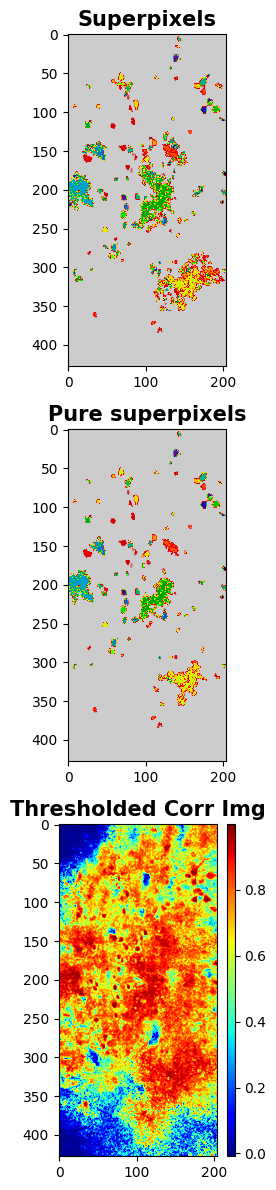

Identified 112 neurons here


In [14]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.95,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':3,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [15]:
pmd_demixer.lock_results_and_continue()

Now in demixing state


In [16]:
num_iters = 40
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.9, 0.7, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':4,  #No ring model
    'ring_radius':10,
    'merge_threshold':0.6,
    'merge_overlap_threshold':0.6,
    'update_frequency':num_iters + 1,
    'c_nonneg':False, #Voltage can fluctuate above/below baseline
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")



100%|███████████████████████████████████████████| 40/40 [00:18<00:00,  2.12it/s]

that took 19.117835998535156
after this step 112 signals identified


In [17]:
pmd_demixer.lock_results_and_continue(carry_background = True)

Now in the initialization state


find superpixels!
find pure superpixels!
prepare iteration!


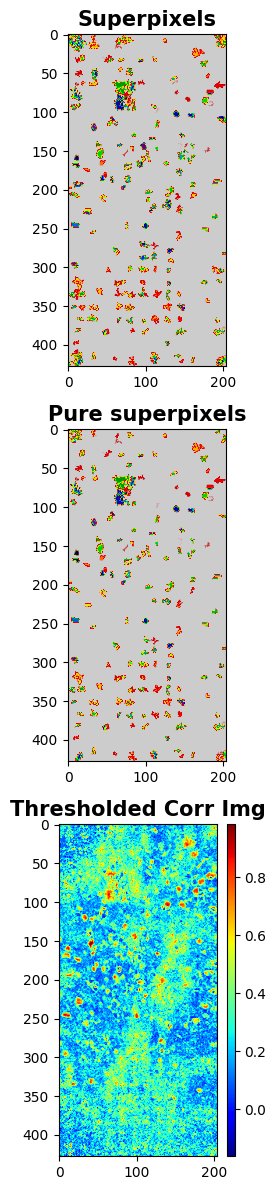

Identified 302 neurons here


In [26]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.8,

    #Mostly stable
    'min_superpixel_size':10,
    'robust_corr_term':0.2,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [28]:
pmd_demixer.lock_results_and_continue(carry_background = False)

Now in demixing state


In [29]:
num_iters = 40
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.9, 0.7, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':4,  #No ring model
    'ring_radius':10,
    'merge_threshold':0.6,
    'merge_overlap_threshold':0.6,
    'update_frequency':num_iters + 1,
    'c_nonneg':False, #Voltage can fluctuate above/below baseline
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")



100%|███████████████████████████████████████████| 40/40 [00:19<00:00,  2.03it/s]

that took 19.991661071777344
after this step 302 signals identified


RFBOutputContext()

/data/home/app2139/fastplotlib/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
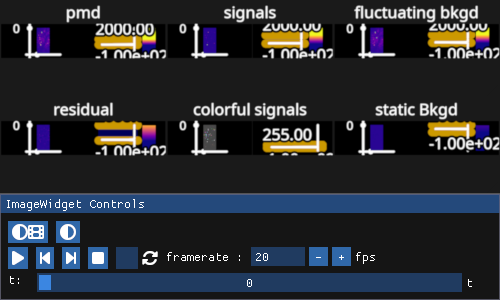

In [30]:
iw = masknmf.visualization.make_demixing_video(pmd_demixer.results,
                    device,
                    show_histogram = True,
                    v_range = [-100, 2000])

iw.show()